In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
from joblib import load
from joblib import dump
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Read Data

In [ ]:
x = pd.read_csv('TCGAdata.txt', sep=" ", header= 0) #files separated by "" and first column=header

y = pd.read_csv('TCGAlabels.txt',header=0, sep=" ",index_col=0)
y=y["x"]


print("Number of nulls in features:", sum(x.isnull().sum())) # No nulls
print("Number of nulls in labels:", y.isnull().sum())

Number of nulls in features: 0
Number of nulls in labels: 0


### 2. Add noise

In order to add noise to the data we added "fake" data points according to the distribution of each class. Our intuition was: first, group the total data by each of the 6 different classes, and for each class, compute the mean and variance of the 2000 features. Then, select and n which means the total data points to add for every class (in total 6*n). In order to generate a fake data point belonging to a class we compute each feature as a random sample from the normal distribution with mean and variacne of the feature belonging to that class. Finally, to add the noise we assign the generated class a random class that is not the one that belongs to it.
For example, in a 2D plot it would be obvious that the generated samples from class 1 would be very similar to class 1 points, but belonging to another class.

We created an add noise function to generate 5 different datasets: the original one with 0 noise, until

In [ ]:
#join features and labels
z=x.join(y)
groups=z.groupby("x")

#global variables
mean=groups.mean() #dataframe containing mean of each of the 6 classes
var=groups.var() #variance
classes=["BC","GBM","KI","LU","OV","U"]

def add_noise(dataset, noise):
  #define number of vales to add
  n=int(2000*noise/6)

  #go through each class
  for c in classes:
    class_mean=mean.loc[[c]] #get the mean from the mean dataframe
    class_var=var.loc[[c]] #varaince

    #generate n data points for each class
    for i in range(n):
      data_point= pd.Series(0, index=dataset.columns) #empty frame
      #for each feature
      for col in x.columns:
          mean_feat=class_mean[col][0] #get mean and variance of the feature
          var_feat=class_var[col][0]
          data_point[col]=np.random.normal(mean_feat,var_feat) #generate the data_point feature

      #after the data point is generated append to the dataframe and return the fake set
      classes2=classes.copy()
      classes2.remove(c) #assign a class but excluding the original
      data_point["x"]=np.random.choice(classes2)

      #dataset=dataset.append(data_point, ignore_index=True)
      dataset=pd.concat([dataset, data_point.to_frame().T])
  return dataset


#% of total data to add
noise = np.array([0,0.20,0.45,0.70])

datasets=[0]*len(noise)
count=0
for i in noise:
  datasets[count]=add_noise(z, i)
  count=count+1

[0, 0, 0, 0]


In order to avoid running the noise algorithm each time we worked on the project, we decided to store the noisy datasets.

In [ ]:
# Assuming datasets is a list of numpy arrays
for idx, dataset in enumerate(datasets):
    np.save(f'dataset_{noise[idx]}.npy', dataset)  # Saves each dataset as a separate .npy file



In [ ]:
#testing our function
loaded_dataset = np.load('dataset_0.0.npy', allow_pickle=True)
print(loaded_dataset.shape)

(2887, 2001)


### 2. Bagging


Bagging, which stands for **Bootstrap Aggregating**, is an ensemble learning technique used to improve the stability and accuracy of machine learning algorithms. It reduces variance and helps to avoid overfitting. Although it is often used in conjunction with decision trees, it can be applied to many types of machine learning algorithms for classification and regression tasks.

Here’s how bagging works:

1. **Multiple Subsets**: Bagging involves creating multiple subsets of the original training dataset, with replacement (bootstrap samples). Each subset is used to train a separate instance of the base model. This means that the same sample can appear more than once in the same subset or in different subsets.

2. **Parallel Training**: Each subset is used to train a model independently and in parallel with others. This means that bagging can efficiently utilize multicore processors by training different models on different cores.

3. **Aggregation of Outputs**: For classification tasks (like in your example with `RandomForestClassifier`), the outputs of individual models are combined through a majority voting mechanism. For regression tasks, the final output is typically the average of all the individual predictions.

using `BaggingClassifier` with `RandomForestClassifier` as the base estimator:
- **Multiple Random Forests**: Each subset of your training data trains a separate random forest. Each random forest itself is an ensemble of decision trees.
- **Aggregated Decision Making**: The final prediction for a given input is determined by aggregating the predictions from all the random forests (typically by majority voting for classification)


#### 2.1 Finding best model parameter

The first problem we encountered when trainning and testing the algorithm was "which parameters should have our classifier?". We decided that we would recall the `GridSearchCV` in order to find the best parameters to train the model. For simplicity, we only did it for the original data with no noise and kept the parameters for the noisy models.

In [ ]:
#Load 0 noise data
z= np.load(f'dataset_{0}.npy', allow_pickle=True)
x,y = z[:,:-1],z[:,-1]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

# Define the base estimator (Random Forest)
base_estimator = RandomForestClassifier()

# Initialize BaggingClassifier with the base estimator
bagging_clf = BaggingClassifier(base_estimator)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [5,10,15,20]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(bagging_clf, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to find the best parameters
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'n_estimators': 20}
Best Score: 0.988309810218704


We observed that the model tends to work better when the `n_estimators` parameter is larger. This makes intuitive sense because it represents the number of trees to be used in the forest, so given that the algorithm would converge well it has certain similarity to the Law of Large Numbers. Therefore, restricted by our computational power (we run all the code in our laptops and with sklearn, which mainly calls CPU) we selected 20.

#### 2.2 Training each level of noise


After defining the model parameters we trained the BaggingClassifier for each of the level of noise and plot the recall as a function of noise. We used recall bacause in medicine the cost of false negatives is high so we thought it would be sensible to use it.

Recall: 0.9878892733564014
Recall: 0.8645357686453576
Recall: 0.8113456464379947
Recall: 0.7222870478413069


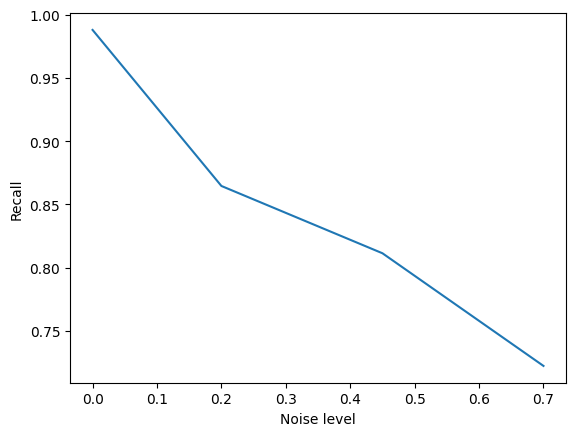

In [ ]:
# noise_level = np.array([0,0.27,0.45,0.72]) #np.arange(0,0.73,0.09)
accuracy_list = []
for i in range (len(noise)):
    # data = add_noise (z,noise_level[i])
    # x,y = datasets.iloc[:,:-1],datasets.iloc[:,-1]
    z= np.load(f'dataset_{noise[i]}.npy', allow_pickle=True)
    x,y = z[:,:-1],z[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
    # Define the base classifier (Random Forest)
    base_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

    # Define the bagging classifier
    bagging_classifier = BaggingClassifier(base_classifier, n_estimators=10, random_state=42)

    # Train the bagging classifier
    bagging_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = bagging_classifier.predict(X_test)

    # Evaluate the performance of the bagging classifier
    recall = recall_score(y_test, y_pred, average='weighted')

    print("Recall:", recall)
    accuracy_list.append(recall)
plt.plot(noise, accuracy_list)
plt.xlabel('Noise level')
plt.ylabel('Recall')
plt.show()





As a result we can see that the predicitive performance without noise is very good (99%), but as we keep adding noise, the recall metric decreases linearly. It makes sense, since we added noise through generating new fake samples that should belong to another cluster. Therefore even if the algorithm detects the optimal features and cuttoffs the number of prediction error should be expected to increase.

Also note that differently from Porject 1, we decided to run the algorithm with out PCA in order to train with the original features (we use PCA with the 2nd dataset) and we still obtained very similar results compared to the best predictor obtrained (which was Logistic Regression using cross-validation).

#### 2.3 Feature Importance

Finally, we analyzed the feature importance of the Bagging Classifier using Random Forests.

There are many ways of assessing feature importane.
- **Tree-based Models**: When one implements Random Forests or Gradient Boosting sklearn provides methods to asses feature importanve based on the contribution to the entropy/loss function.
-**Permutation importance**: It randomly permutes the values of a feature to see how it affects the model performance.
- **Linar Models Coefficients**: When using linear models the absolute value of the coefficients can be used as a measure of the importance.
-**Tree Interpreter**: It studies the conbtribution of each feature within an ensemble model.
- **SHAP**: Represents the contribution of each feature across all combinations (uses game theory).
- **LASSO**: Lasso regularization also comes with a way of weighting feature coefficients.
- **Recursive Feature Elimination and Recursive Feature Addition**: Delete/add features progeressively to rank features.
- **XGBoost**: depends on how many time a feature is used to split data across the ensemble of trees.

Due to the context of the problem we decided to use permutation importance, as it can be used for any model (not only trees) and it has an intuitive way of computing the weights (no black-box) as it focuses on the change on the model error when features are shuffled, allowing to understand the interaction between variables. Moreover, it does not require to retrain the model, which will help to ease the computational workload.Here is how the algorithm works:

1- Pick a feature

2- Shuffle the column
3- Predict results using the shuffled feature

4- Compute scores and compare with the original

5- Repeat with other columns

On the other hand, permutation importance can be a bad method if the model is overfitted or used for unsupervised learning (which is not the case). Finally, having a lot of correlated variables can effect its performance, so maybe it would be more suitable for datasets with less features.

We implemented the method using the `feature_importance` function of sklearn. First, we computed the feature importance for each level of noise and printed the accuracy of the model and the plot of all the non zero features. However, as one can observe, the plots were not very clean and it was a bit computationally intensive so we stored the results of each permutation importance.

Training the model...1
Making predictions...
Accuracy: 0.867579908675799
Computing permutation importance...
Plotting feature importance...


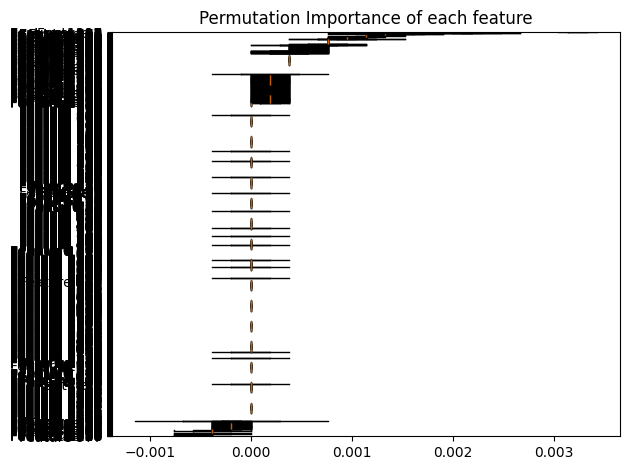

Training the model...2
Making predictions...
Accuracy: 0.7664907651715039
Computing permutation importance...
Plotting feature importance...


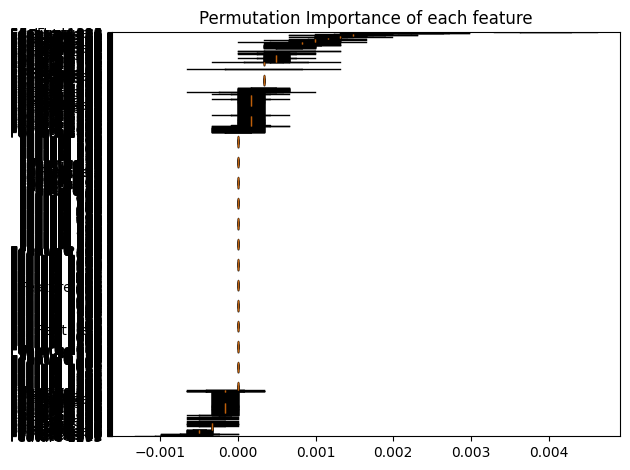

Training the model...3
Making predictions...
Accuracy: 0.6884480746791132
Computing permutation importance...
Plotting feature importance...


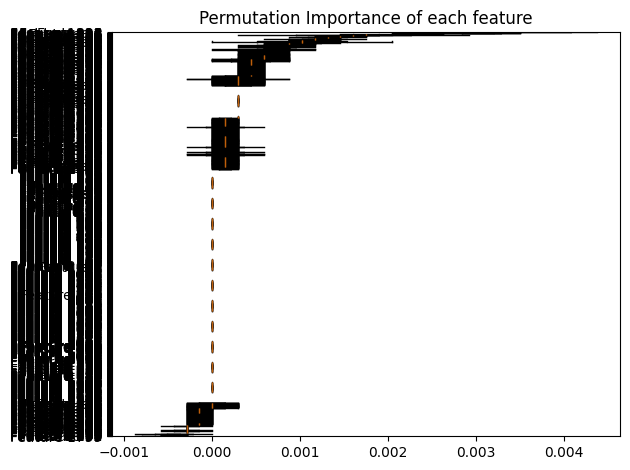

In [ ]:
for i in range (1,len(noise)):

    z= np.load(f'dataset_{noise[i]}.npy', allow_pickle=True)
    x,y = z[:,:-1],z[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)
    # Define the base classifier (Random Forest)
    print(f"Training the model...{i}")
    base_classifier = RandomForestClassifier(n_estimators=5, random_state=42)
    bagging_classifier = BaggingClassifier(base_classifier, n_estimators=5, random_state=42)
    bagging_classifier.fit(X_train, y_train)

    # Prediction
    print("Making predictions...")
    y_pred = bagging_classifier.predict(X_test)

    # Evaluate the performance
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Compute permutation importance
    print("Computing permutation importance...")
    result = permutation_importance(bagging_classifier, X_train, y_train, n_repeats=2, random_state=42, n_jobs=-1)
    dump(result, rf'C:\Users\purus\Documents\Chalmers\Big_data\hw2\results\bagging_permutation/permutation_importance_result_{noise[i]}.joblib')
    loadedresult= load(rf'C:\Users\purus\Documents\Chalmers\Big_data\hw2\results\bagging_permutation/permutation_importance_result_{noise[i]}.joblib')
    # Plotting permutation importances
    print("Plotting feature importance...")
    feature_names = [f"Feature {i+1}" for i in range(X_train.shape[1])]  # Assuming you don't have feature names
    sorted_idx = result.importances_mean.argsort()
    plt.figure()
    plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=[feature_names[i] for i in sorted_idx])
    plt.title("Permutation Importance of each feature")
    plt.tight_layout()
    plt.show()


We loaded each of the results and plotted the top N features for each level of noise (we selected N=10) and included a plot showing how the number of important features (features with an importance different than 0) changes with the noise level. Note that in the black plots of above most of the features have 0 importance and some of them are negative: Zero or near-zero values in feature importance scores suggest that shuffling the values of that particular feature did not affect the performance of the model, meaning that the model does not rely on that feature to make predictions (aka not important). Negative values mean that the predictions on the shuffled feature were more accurate, which usually is interpreted as a feature that has low importance but due to randomness improved the model in that particular shuffling.

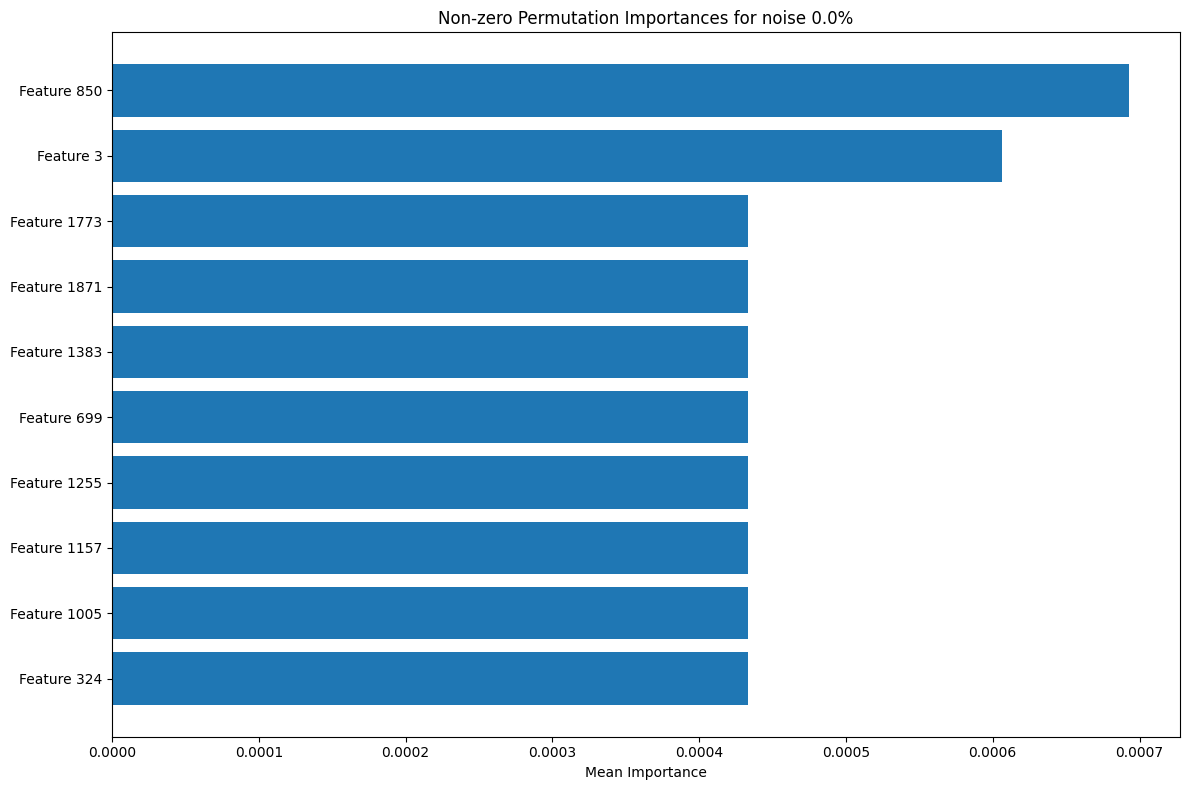

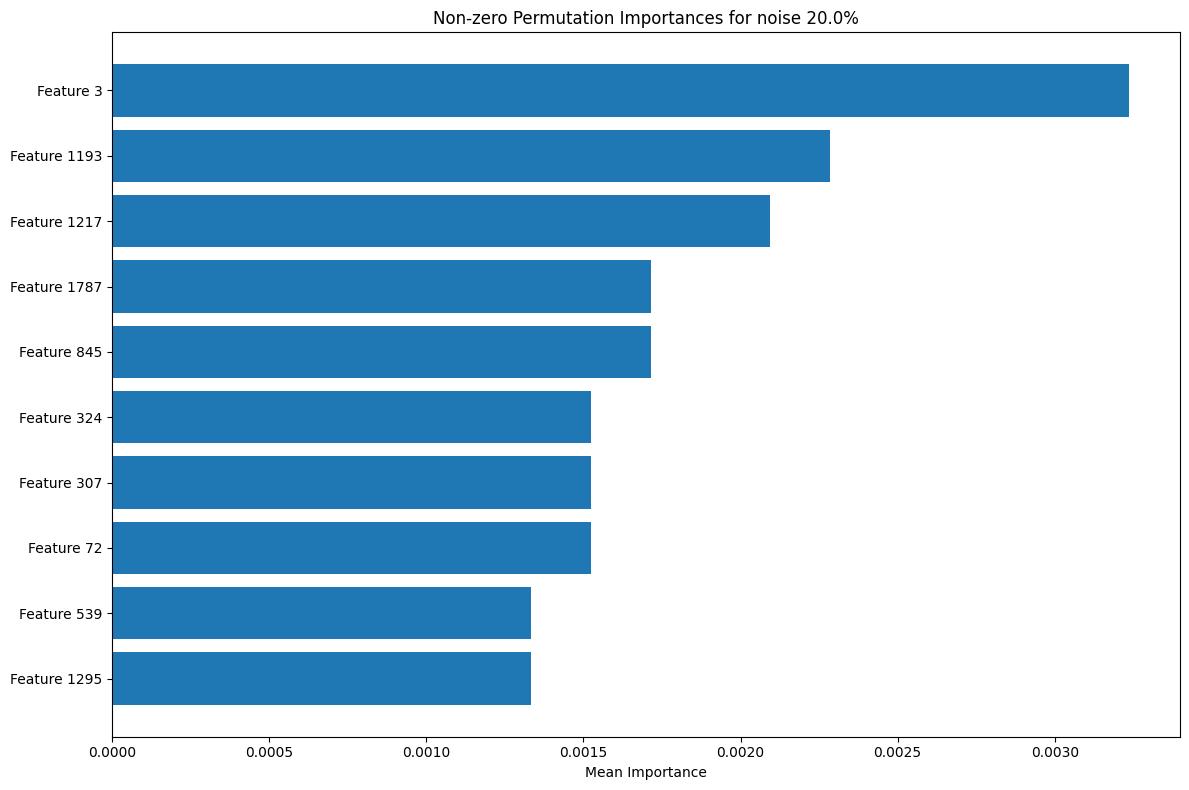

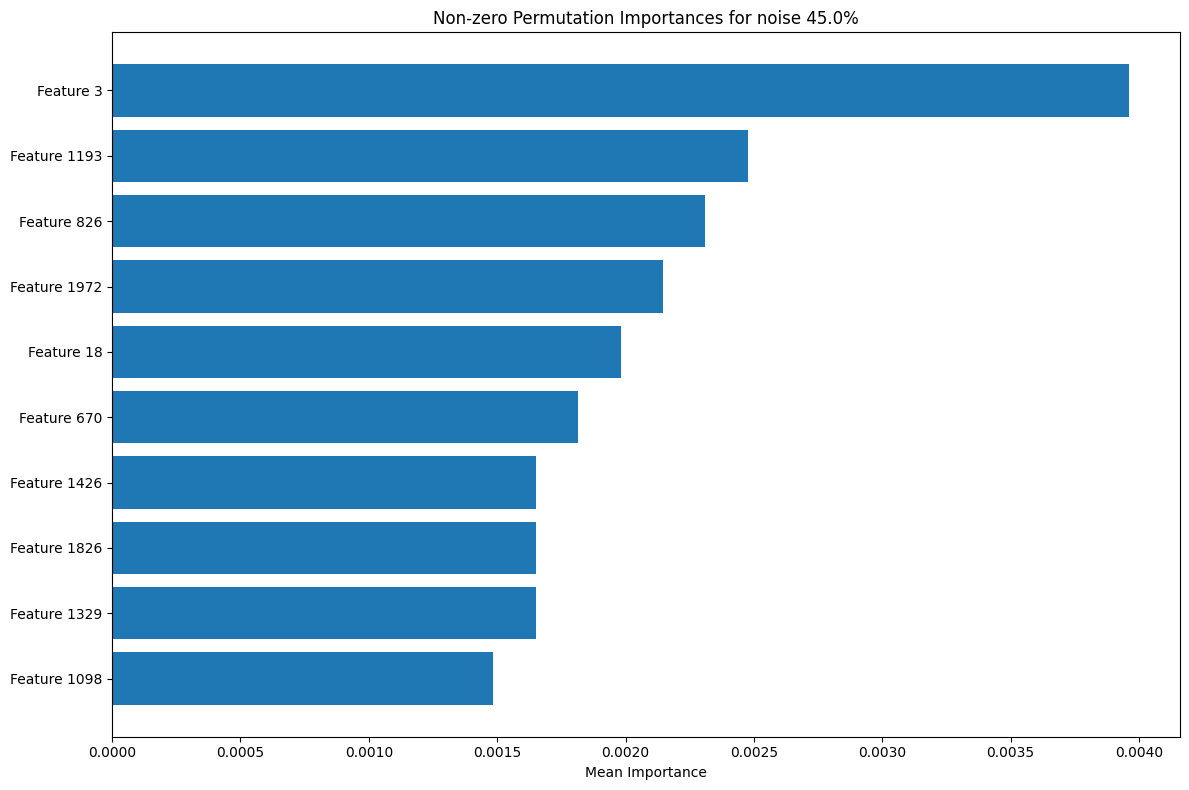

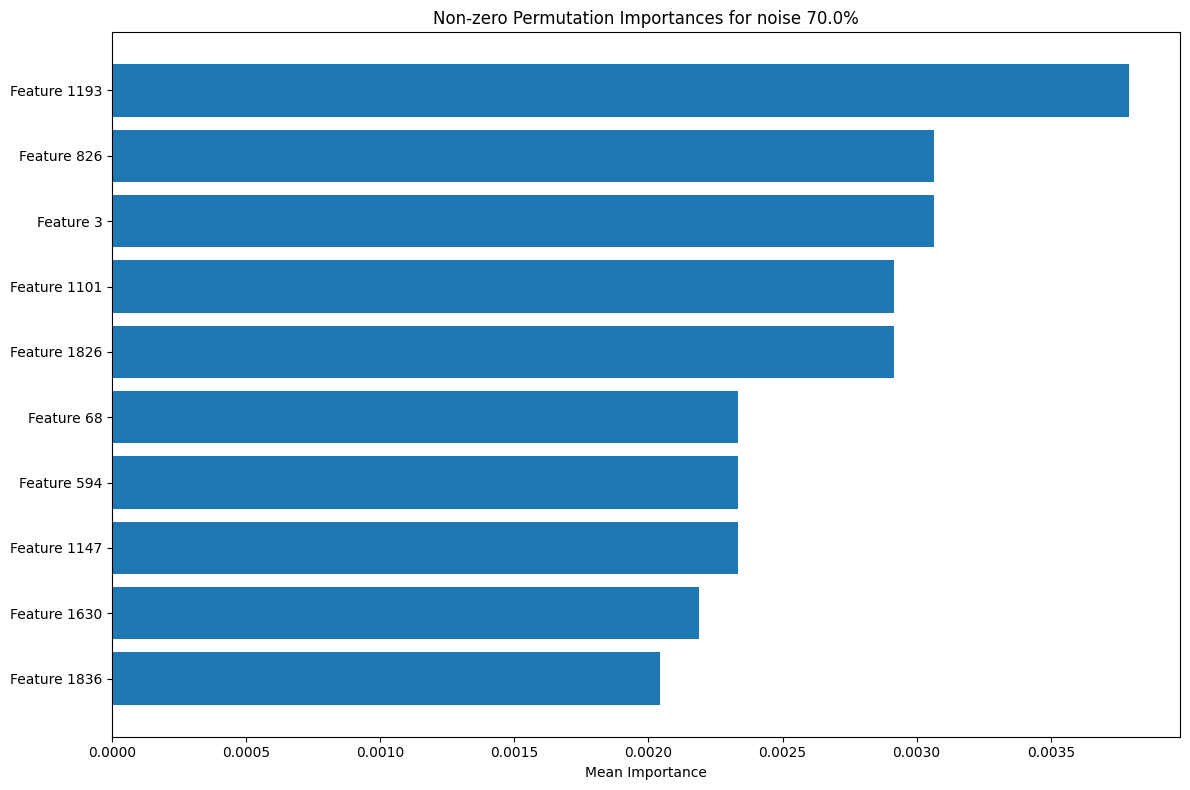

[53, 425, 724, 842]


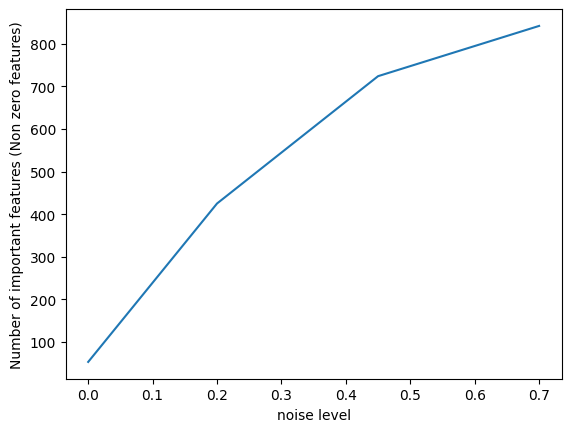

In [ ]:
noise = np.array([0,0.20,0.45,0.70])
number_of_important_features = []

for i in range (len(noise)):
    loadedresult= load(rf'/content/permutation_importance_result_{noise[i]}.joblib')
    importance_means = loadedresult.importances_mean[sorted_idx]

    non_zero_indices = np.where(loadedresult.importances_mean != 0)[0]
    non_zero_importances = loadedresult.importances_mean[non_zero_indices]

    #get the indexes of top N important features sorted by absolute value
    n = 10  # Number of values you want to keep
    # Get the indices of elements sorted by absolute values in descending order
    sorted_abs_indices = np.argsort(np.abs(non_zero_importances))[::-1]
    # Get the top n indices
    top_n_indices = sorted_abs_indices[:n]
    # Sort the top n indices by the original values
    sorted_indices = np.argsort(non_zero_importances[top_n_indices])[::-1]
    # Get the indices of the top n elements with highest absolute values
    sorted_idx = top_n_indices[sorted_indices][::-1]

    # Filter feature names for non-zero importances
    non_zero_feature_names = [f"Feature {i+1}" for i in non_zero_indices]
    number_of_important_features.append(len(non_zero_feature_names))

    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(sorted_idx)), non_zero_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [non_zero_feature_names[i] for i in sorted_idx])
    plt.xlabel('Mean Importance')
    plt.title(f'Non-zero Permutation Importances for noise {noise[i]*100}%')
    plt.tight_layout()
    plt.show()

print(number_of_important_features)
plt.plot(noise,number_of_important_features)
plt.xlabel('noise level')
plt.ylabel('Number of important features (Non zero features)')
plt.show()


Top 10 features for:
- 0 noise: 850, **3**, 1773, 1871, 1383, 699, 1255, 1157, 1005, **324**
- 20% noise: **3**, **1193**, 1217, 1787, 845, **324**, 307, 72, 539, 1295
- 45% noise: **3**, **1193**, **826**, 1972, 18, 670, 1426, 1826, 1329, 1098
- 70% noise: **1193**, **826**, **3**, 1101, 1826, 68, 594, 1147, 1630, 1836

If we consider the top 10 features of the 0 model as the true top features, we can see that noise had a huge impact in the algorithm and makes it really confused. Features 3 and 324 can be found in the top features with noise but none of the others appear in the top 10. Moreover there is some "spurious" agreement between the features 1193 and 826 of the noisy data, which are in the range of top 50 - top 100 features in the 0 noise data.

Finally, as one would expect with the assumption of "the algorithm gets confused when you add noise" the number of features that are considered somehow important increase linarly with the level of noise.



**Boosting**

We study Boosting in the 2nd Notebook